**Deep Kalman Filter example with Roessler: true model, linear or nonlinear, fully observable.**



In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import scipy.io as sio
import pickle
import sys

DKFDirectory = '..'
sys.path.append(DKFDirectory)
import CreateTrainingSet_Roessler_4DKF

from DeepKalmanFilter.main import main
from DeepKalmanFilter.ConstructLaplacianMatrices import *
from DeepKalmanFilter.ConstructSGMatrices import *
from DeepKalmanFilter.ConstructTVMatrices import *
from DeepKalmanFilter.Utility import *
WorkingDirectory = './'

Observability Grammian =  [[ 3.   -0.2  -0.2 ]
 [-0.2   0.02  0.02]
 [-0.2   0.02  0.02]]


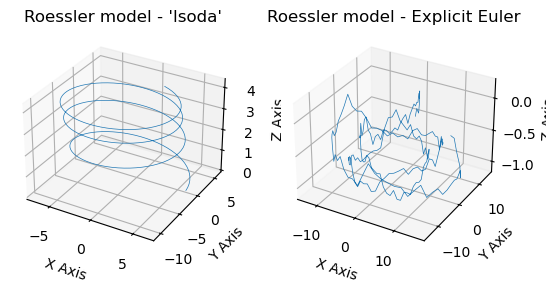

In [2]:
# dataset creation:
Experiment = 'Roes2'
if 1: # linear model
    a=0; b=0.5; c=0.1; beta=0
    dt=0.1
    y0 = np.array([[6.0],[0],[0]])
    if Experiment == 'Roes1':
        nsteps = 500
        sigma_P = 1.*10**-15
    elif Experiment == 'Roes2':
        nsteps = 200
        sigma_P = 3.*10**0
    #endif 
else: # nonlinear model
    a=0.1; b=0.1; c=9; beta=1.
    dt=0.01
    nsteps = 500
    #y0 = np.array([[6.0],[0],[0]])
    y0 = np.array([-9.61471749e+00,  7.77071996e+00,  5.51106905e-03])
#endif
TEnd = dt * nsteps
# NB: here "sigma_Q" adds model error to the dataset! (not to be used for e.g discretization model error)
CreateTrainingSet_Roessler_4DKF.create(Experiment=Experiment,a=a,b=b,c=c,beta=beta,yBegin=y0,\
                                       dt=dt,TEnd=TEnd,sigma_Q=1.*10**-15,sigma_R=1.*10**0,sigma_P=sigma_P)

In [3]:
## Kalman Filter state-estimates:
TrainInstanceInd = 0
Experiment = sio.loadmat('Experiment.mat',squeeze_me = True)['Experiment']
Model = loadPickle(f'ModelExp{Experiment}.mat')
A = Model['AInitExplEuler'] # 'AInit' or 'AInitExplEuler'
nx = A.shape[1]; print("nx = ",nx)
B = np.zeros((nx,1)); B = A @ B; print("B.shape = ",B.shape)
C = np.atleast_2d( sio.loadmat(f'CExp{Experiment}.mat',squeeze_me = True)['C'] )
Q = Model['Q_KF']
R = Model['RInit']
WorkingTrainingSetName = f'LatestTrainingSetExp{Experiment}.mat'
TrainingSet = loadPickle(WorkingDirectory+WorkingTrainingSetName)
Inputs = TrainingSet[0][TrainInstanceInd]; print("Inputs.shape = ",Inputs.shape)
Measurements = TrainingSet[1][TrainInstanceInd]
FirstState = TrainingSet[2][TrainInstanceInd]
TrajectoryTrue = TrainingSet[3][TrainInstanceInd]
StateTrue = TrainingSet[4][TrainInstanceInd]
Dynamic = TrainingSet[5][TrainInstanceInd]
x0 = FirstState.copy()
y = np.zeros(Measurements.shape)
x = np.atleast_2d(x0.copy())
N = Measurements.shape[1]; print("N = ",N)
X_hist = np.zeros((x0.shape[0],N))
X_hist[:,[0]] = x0.copy()
pe = np.zeros(y.shape)
y_hist = np.zeros(Measurements.shape)
P = np.diag(np.ones(nx)) # suppongo che l'errore iniziale di stima dello stato sia grande.
for i in range(0,N-1):
    x = A @ x + B @ np.atleast_2d(Inputs[:,[i]])
    y[:,[i+1]] = C @ x;
    P = A @ P @ A.T + Q
    Lambda = C @ P @ C.T + R
    #print("Lambda = ",Lambda," , C = ",C," , P = ",P)
    tmp = np.linalg.solve(Lambda.T, C @ P.T); L = tmp.T;  #L = P*C.T*invert(Lambda)
    #print("L.shape = ",L.shape)
    pe[:,[i+1]] = Measurements[:,[i+1]] - y[:,[i+1]]
    x = x + L @ pe[:,[i+1]]
    y_hist[:,[i+1]] = C @ x
    #P = P - L*C*P  #P*C.T*inv(Lambda)*C*P
    P = P - P @ C.T @ np.linalg.inv(Lambda) @ C @ P
    #print "P = ",P
    #print "norm(P) = ",np.linalg.norm(P)
    X_hist[:,i+1] = np.squeeze(x[:,0])
#endfor

nx =  3
B.shape =  (3, 1)
Inputs.shape =  (1, 200)
N =  201


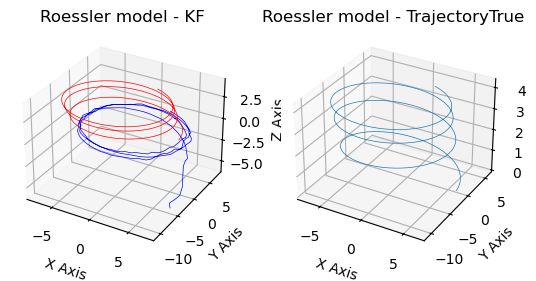

In [4]:
ax = plt.figure(1).add_subplot(1,2,1,projection='3d')
ax.plot(*X_hist, 'b-', lw=0.5)
ax.plot(*TrajectoryTrue, 'r-', lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Roessler model - KF")
ax = plt.figure(1).add_subplot(1,2,2,projection='3d')
ax.plot(*TrajectoryTrue, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Roessler model - TrajectoryTrue")
plt.show()

In [5]:
print("Lambda = ",Lambda)
print("L = ",L)

Lambda =  [[1.17969692]]
L =  [[ 0.15232465]
 [-0.04560869]
 [-0.0266256 ]]


In [6]:
TrainingBatchNum = 300 #30# 100 #300 #150 #1000
TrainingBatchSize = 1

# DKF parameters setting:
NetParameters = {}
### General parameters:
NetParameters['Experiment'] = sio.loadmat('Experiment.mat',squeeze_me = True)['Experiment']
NetParameters['Layers'] = sio.loadmat(f'LayersExp{NetParameters["Experiment"]}.mat',squeeze_me = True)['Layers']
NetParameters['Model'] = loadPickle(f'ModelExp{NetParameters["Experiment"]}.mat')
NetParameters['C'] = np.atleast_2d( sio.loadmat(f'CExp{NetParameters["Experiment"]}.mat',squeeze_me = True)['C'] )
NetParameters['StateDimension'] = NetParameters['C'].shape[1]
NetParameters['ObservationDimension'] = NetParameters['C'].shape[0]
NetParameters['WeightMats'] = 'Input'  #Supported values: Input, Identity  
NetParameters['HiddenDynamicsNumber'] = 1
NetParameters['HiddenDynamicsDimension'] = [sio.loadmat(f'HiddenDynDimExp{NetParameters["Experiment"]}.mat',squeeze_me = True)['HiddenDynDim']]*NetParameters['HiddenDynamicsNumber']
NetParameters['ActivateModelDiscovery'] = 'No' #'No','Yes'
### Learning parameters:
NetParameters['BackPropagation'] = 'Truncated' #'Complete','Truncated'   
NetParameters['ProjectDynamics'] = 'No' #'No','Yes'
NetParameters['Jacobians'] = 'Approximated' #'Approximated', 'Algebraic'  
NetParameters['FiniteDifferences'] = 'Central' #'Supported values: 'Forward', 'Backward', 'Central'  
NetParameters['FiniteDifferencesSkip'] = 1e-9 
NetParameters['GainLearningRate'] = (1e-2) / TrainingBatchSize
NetParameters['GainLearningRateReduction'] = 1
NetParameters['GainLearningRateIncrease'] = 1e2
NetParameters['DynamicsLearningRate'] = (1.8e-2) / TrainingBatchSize
NetParameters['DynamicsLearningRateReduction'] = 0.2
### Loss function parameters:
Pen1Val = 1e0
Pen2Val = np.ones(NetParameters['Layers']) * 1e0
NormPen = max(Pen1Val, Pen2Val.max())
NetParameters['Penalty0'] = 1.e6 # lambda_N
NetParameters['Penalty1'] = np.ones(NetParameters['Layers']) * Pen1Val / NormPen # measurement error term
NetParameters['Penalty2'] = Pen2Val / NormPen # correction error term
NetParameters['Penalty3'] = 1.e0 / (NetParameters['StateDimension'] * NetParameters['ObservationDimension']) # lambda_D
NetParameters['Penalty4'] = 0.01 #0.2 # soft-thresholding
#NetParameters['WinLen'] = 31
#NetParameters['StencilA0'], NetParameters['StencilA1'] = ConstructSGMatrices(NetParameters['WinLen'])
NetParameters['L'], NetParameters['LtL'] = ConstructLaplacianMatrices( NetParameters['Layers'], NetParameters['Model']['SamplingTimes'] )
### Adam (learning optimizer) parameters:
NetParameters['Optimizer'] = 'Adam'
NetParameters['BetaMoment1'] = 0.9
NetParameters['BetaMoment2'] = 0.999
### corrector gains parameters:
NetParameters['SharedWeights'] = 'No' #'No','Yes'
NetParameters['Initialization'] = 'DeterministicComplete'   #'Random', 'Deterministic', 'DeterministcComplete'  
NetParameters['InitializationMean'] = 0
NetParameters['InitializationSigma'] = 0.0001
NetParameters['AdamEpsilon'] = 1e-16
### Learning stop condition parameters:
NetParameters['TrainingConditionStop'] = 'Residues' #'Whiteness', 'Residues'  
NetParameters['ResidueDecreaseThreshold'] = 1e-3
NetParameters['ActivateWhitenessMask'] = 'Yes'
NetParameters['WhitenessLagCounter'] = 1
NetParameters['WhitenessIterationCheck'] = 20
NetParameters['WhitenessUpdateCheck'] = 8
NetParameters['WhitenessDecreaseThreshold'] = -1e-3

# Save net parameters
sio.savemat('DefaultNetParameters.mat', {'NetParameters': NetParameters})

In [7]:
ShowStates = main(WorkingDirectory,NetParameters,TrainingBatchSize,TrainingBatchNum)

KeyboardInterrupt: 

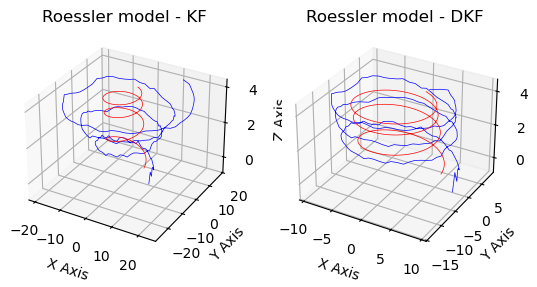

In [11]:
ax = plt.figure(1).add_subplot(1,2,1,projection='3d')
ax.plot(*X_hist, 'b-', lw=0.5)
ax.plot(*TrajectoryTrue, 'r-', lw=0.5)
#ax.plot(*Measurements, 'g-', lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Roessler model - KF")
ax = plt.figure(1).add_subplot(1,2,2,projection='3d')
ax.plot(*ShowStates.T, 'b-', lw=0.5)
ax.plot(*TrajectoryTrue, 'r-', lw=0.5)
#ax.plot(*Measurements, 'g-', lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Roessler model - DKF")
plt.show()